# Data Curation

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## Imports and environment setup

In [26]:
# imports

# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

from utils.items import Item
from utils.data_loader import ItemLoader

In [38]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Load data

Instead of loading the entire data, we will load a subset and perform our experiments on it before scaling it up to a bigger dataset


In [4]:

dataset = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023",  # dataset identifier (from Hugging Face Hub)
    f"raw_meta_Appliances",             # specific subset of the dataset
    split="full",                       # which split of the dataset we want (train/test/full.)
    trust_remote_code=True             
)


In [5]:
dataset

Dataset({
    features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
    num_rows: 94327
})

## EDA

In [6]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


Investigating a single datapoint from the dataset. Each point in the dataset is a dictionary

In [7]:
dataset[0].keys()

dict_keys(['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'])

In [8]:
import random

datapoint = dataset[random.randint(0,len(dataset)-1)]

print(f'Title: {datapoint["title"]} \nType: {type(datapoint["title"])}\n\n')
print(f'Description: {datapoint["description"]}\nType: {type(datapoint["description"])}\n\n')
print(f'Features: {datapoint["features"]}\nType: {type(datapoint["features"])}\n\n')
print(f'Details: {datapoint["details"]}\nType: {type(datapoint["details"])}\n\n')
print(f'Price: {datapoint["price"]}, \nType: {type(datapoint["price"])}\n\n')

Title: GE WB44K5013 Genuine OEM Upper Bake Element for GE Electric Ovens 
Type: <class 'str'>


Description: ['Product Description', 'This high quality Genuine OEM GE Appliances Upper Bake Element (WB44K5013) is the source of heat when baking . The Upper Bake Element is the upper bake element and has approximate dimensions of L: 20" x W: 14" x H: 2.5". Please be aware that it is recommended to disconnect the appliance from all utilities prior to installation of the Upper Bake Element.Compatible Models: JCKS05BA1BB, JKP13GP3BG, JKP13GP4BG, JKP13GT1BB, JKP13GV1BB, JKP14WP3WG, JKP14WT1WW, JKP14WV1WW, JKP15AV1AA, JKP15AW1AA, JKP15AW2AA, JKP15BW1BB, JKP15BW2BB, JKP15WW1WW, JKP15WW2WW, JKP16GP1BG, JKP16GP2BG, JKP16GP3BG, JKP16GP4BG, JKP16GT1BB, JKP16GT2BB, JKP16GV1BB, JKP17WP1WG, JKP17WP2WG, JKP17WP3WG, JKP17WT1WW, JKP17WT2WW, JKP17WV1WW, JKP18AS1AA, JKP18AT1AA, JKP18AT2AA, JKP18AV1AA, JKP18AW1AA, JKP18AW2AA, JKP18BW1BB, JKP18BW2BB, JKP18WW1WW, JKP26GP3BG, JKP26GP4BG, JKP26GT1BB, JKP26GV1BB,

Lets check how many have datapoints have the price feature. This is to check the distribution of the data. 

In [9]:
count = 0
for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            count += 1
    except ValueError:
        pass

print(f'There are {count:,} datapoints with prices which is {(count/len(dataset))*100:,.2f}% of the data')

There are 46,726 datapoints with prices which is 49.54% of the data


For the items with prices, let us understand the distribution of the data for the prices. Additionally, we will also try to understand the distribution of the text data based on its length of contents which includes the title, description, features and details of the product. 

In [10]:
prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError:
        pass

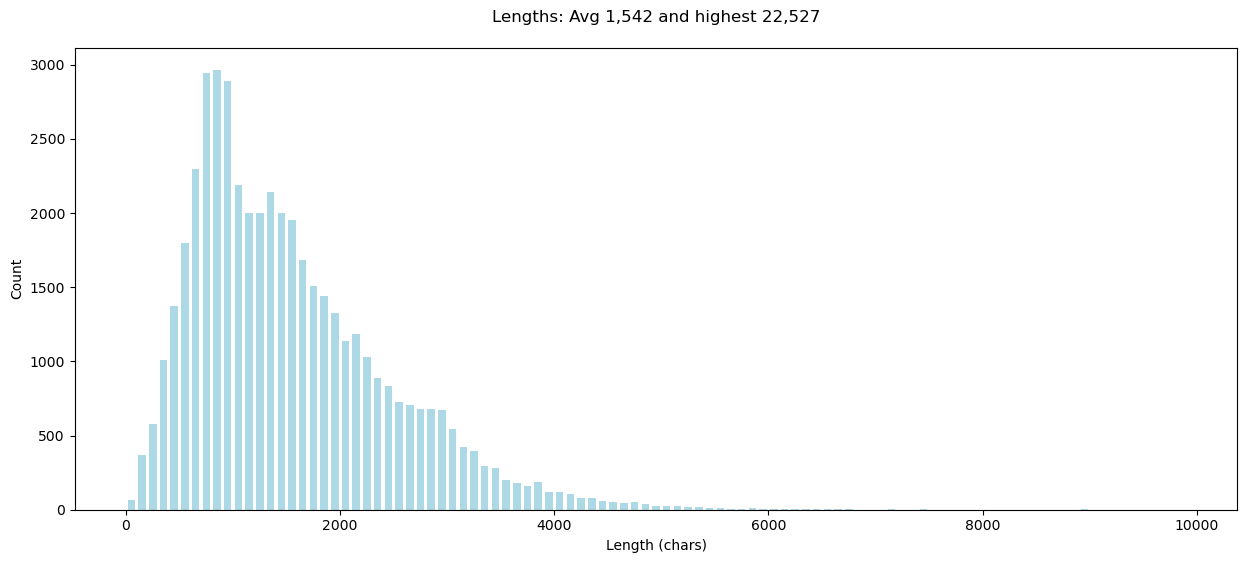

In [11]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 10000, 100))
plt.show()

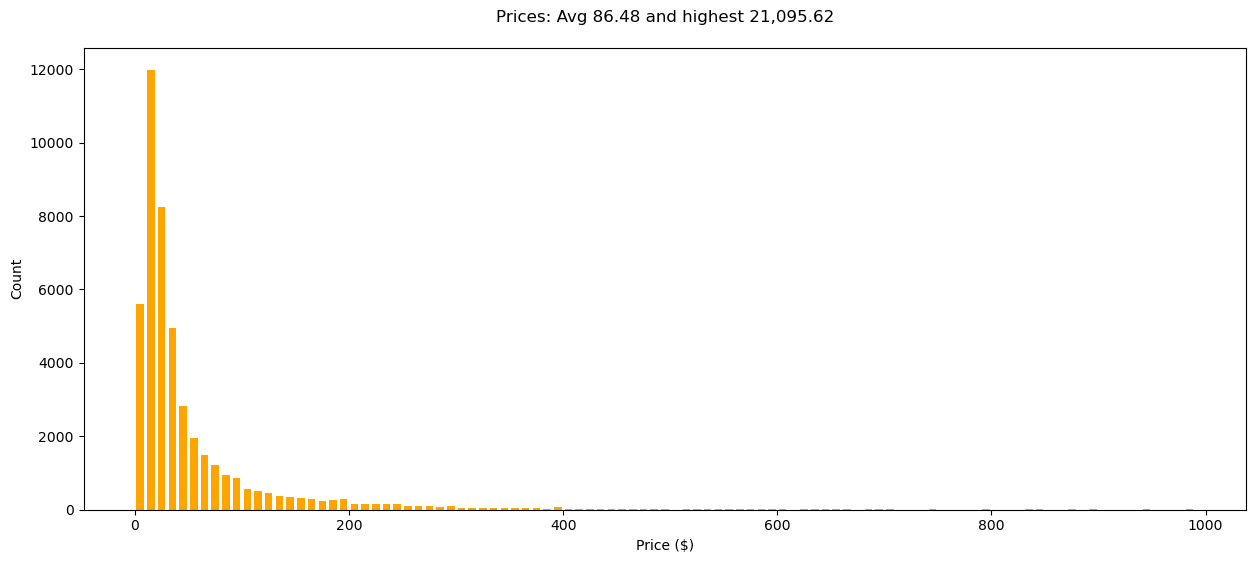

In [12]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [13]:
items = []

for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError:
        pass


In [21]:
print(f'There are {len(prices)} datapoints with prices out of which {len(items)} items which has enough useful information that can be used for training ')

There are 46726 datapoints with prices out of which 29191 items which has enough useful information that can be used for training 


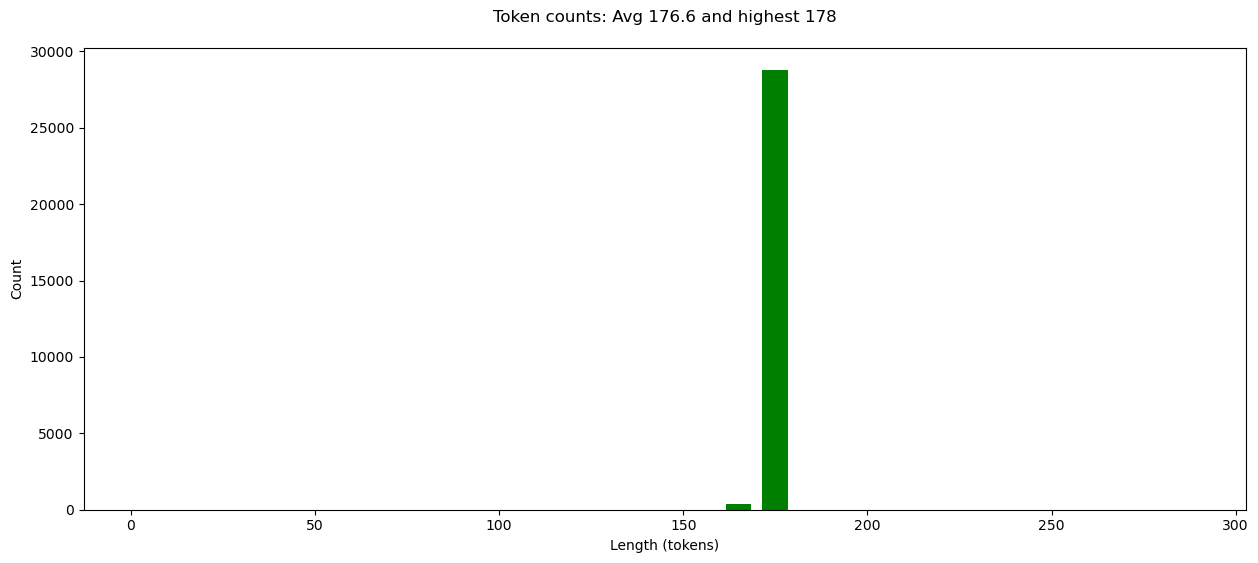

In [24]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

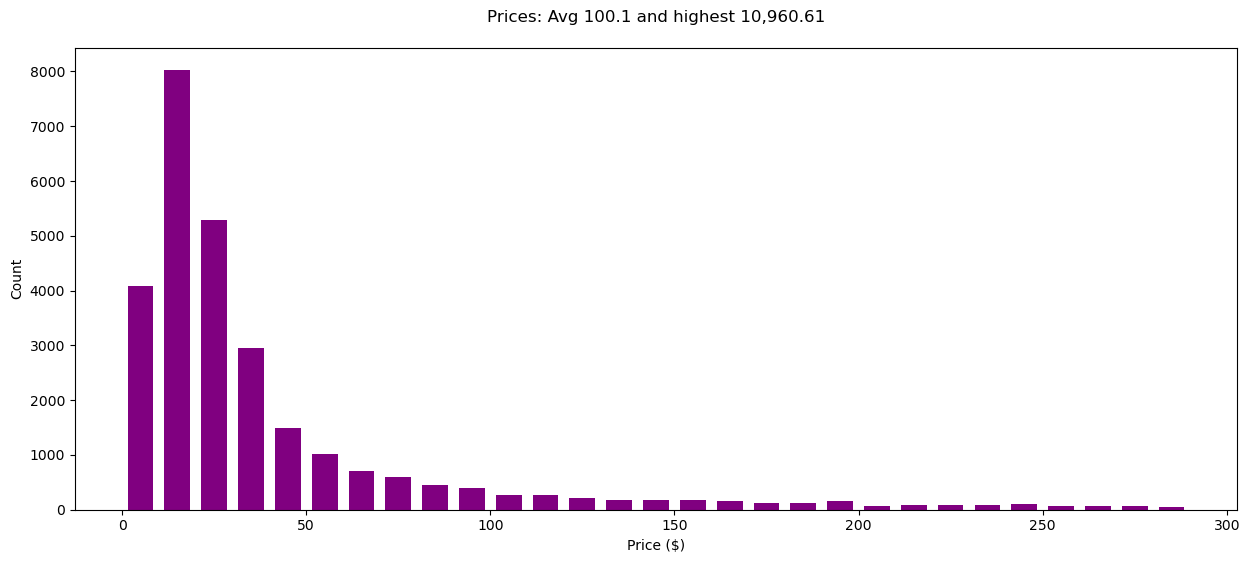

In [25]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

In [23]:
print(items[29190].prompt)

How much does this cost to the nearest dollar?

Refrigerator Defrost Thermostat Replacement for Whirlpool Refrigerator - Compatible with Defrost Thermostat
UpStart Components Replacement Refrigerator Defrost Thermostat for Whirlpool RefrigeratorPlease note This is an UpStart Components Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by UpStart Components. UpStart Components Replacement Refrigerator Defrost Thermostat for Whirlpool Refrigerator Ultra durable, high quality material resists wear and tear over time. Easy at-home installation. An affordable way to extend the life

Price is $6.00


In [16]:
items[150].prompt

'How much does this cost to the nearest dollar?\n\n1Pack Electric Stove Range Burner Receptacle Kit 330031 Universal stove receptacle For Whirlpool Kenmore Maytag and Whirlpool\nFeatures Brand New & High-Quality parts (Not Genuine). According to the original factory specifications. Strict quality control standards to Build and test. Design improved for more durability, Stable and updated characteristics, high reliability. Perfect match and Good Choice for Direct replacement of original Specifications Item Electric Stove Range Burner Receptacle Kit 330031 Manufacturer Part Number 330031 Replaces Part Numbers RR124, 3374, 42147, 42153, 71930, R300, TS300, Compatibility Universal stove receptacle for Maytag and Whirlpool. Package Include 1Pack x Electric Stove Range Burner Re\n\nPrice is $8.00'

# Scale up dataset

We will extend our dataset to a greater coverage and craft a dataset of about 400,000 items covering multiple types of products. We will mainly look at all datasets of all the items that we might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [27]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [39]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load(workers=os.cpu_count()))


Loading dataset Automotive


100%|███████████████████████████████████████| 2004/2004 [12:23<00:00,  2.69it/s]


Completed Automotive with 911,688 datapoints in 12.6 mins
Loading dataset Electronics


100%|███████████████████████████████████████| 1611/1611 [15:41<00:00,  1.71it/s]


Completed Electronics with 443,473 datapoints in 15.9 mins
Loading dataset Office_Products


100%|█████████████████████████████████████████| 711/711 [01:36<00:00,  7.34it/s]


Completed Office_Products with 240,394 datapoints in 1.7 mins
Loading dataset Tools_and_Home_Improvement


100%|███████████████████████████████████████| 1474/1474 [14:55<00:00,  1.65it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 15.1 mins
Loading dataset Cell_Phones_and_Accessories


100%|███████████████████████████████████████| 1289/1289 [09:25<00:00,  2.28it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 9.6 mins
Loading dataset Toys_and_Games


100%|█████████████████████████████████████████| 891/891 [02:20<00:00,  6.36it/s]


Completed Toys_and_Games with 340,479 datapoints in 2.5 mins
Loading dataset Appliances


100%|███████████████████████████████████████████| 95/95 [00:19<00:00,  4.92it/s]


Completed Appliances with 28,625 datapoints in 0.4 mins
Loading dataset Musical_Instruments


100%|█████████████████████████████████████████| 214/214 [00:30<00:00,  7.00it/s]


Completed Musical_Instruments with 66,829 datapoints in 0.6 mins


In [40]:
print(f'Total items in the dataset: {len(items):,} ')

Total items in the dataset: 2,811,408 


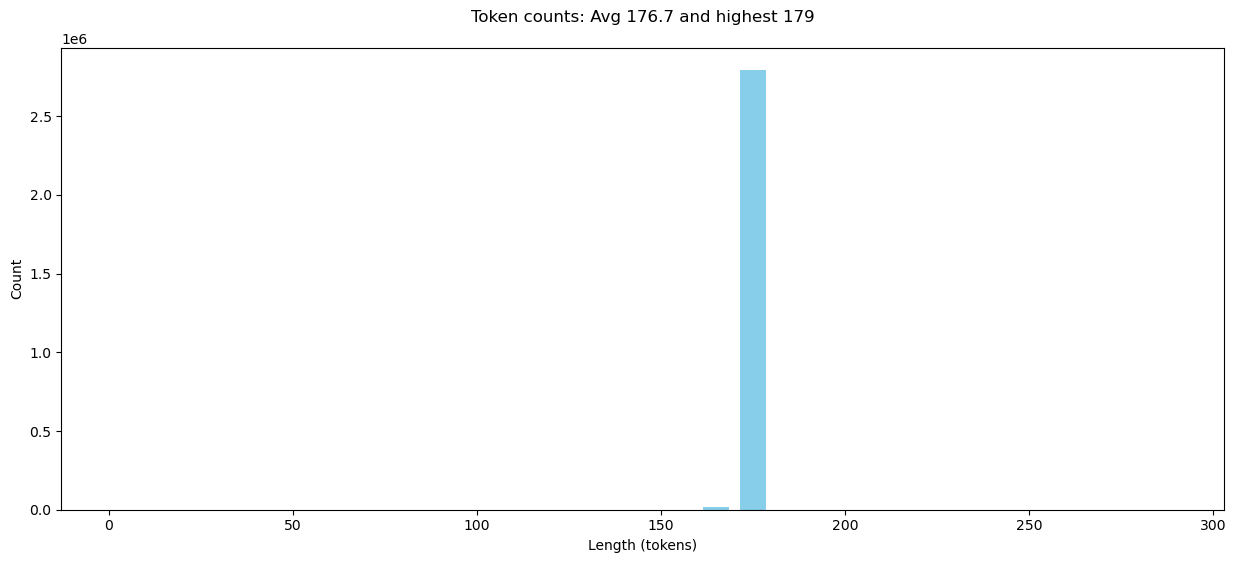

In [41]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

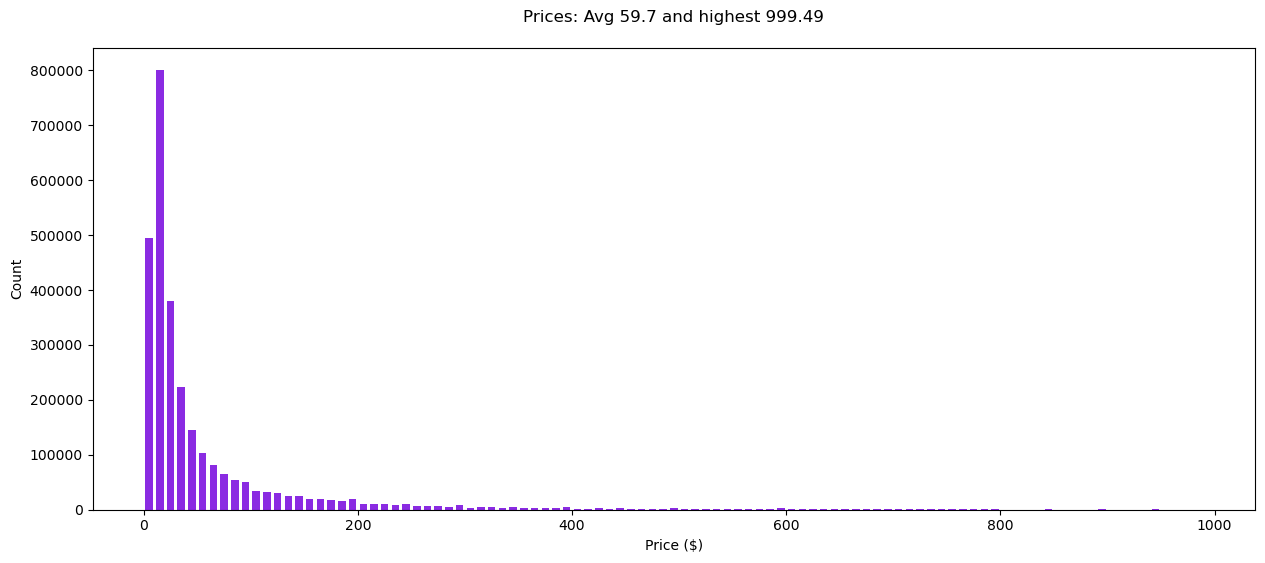

In [42]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

We can see that the prices are highly skewed to cheaper products. As part of balancing the dataset, we will have to handle this skewness

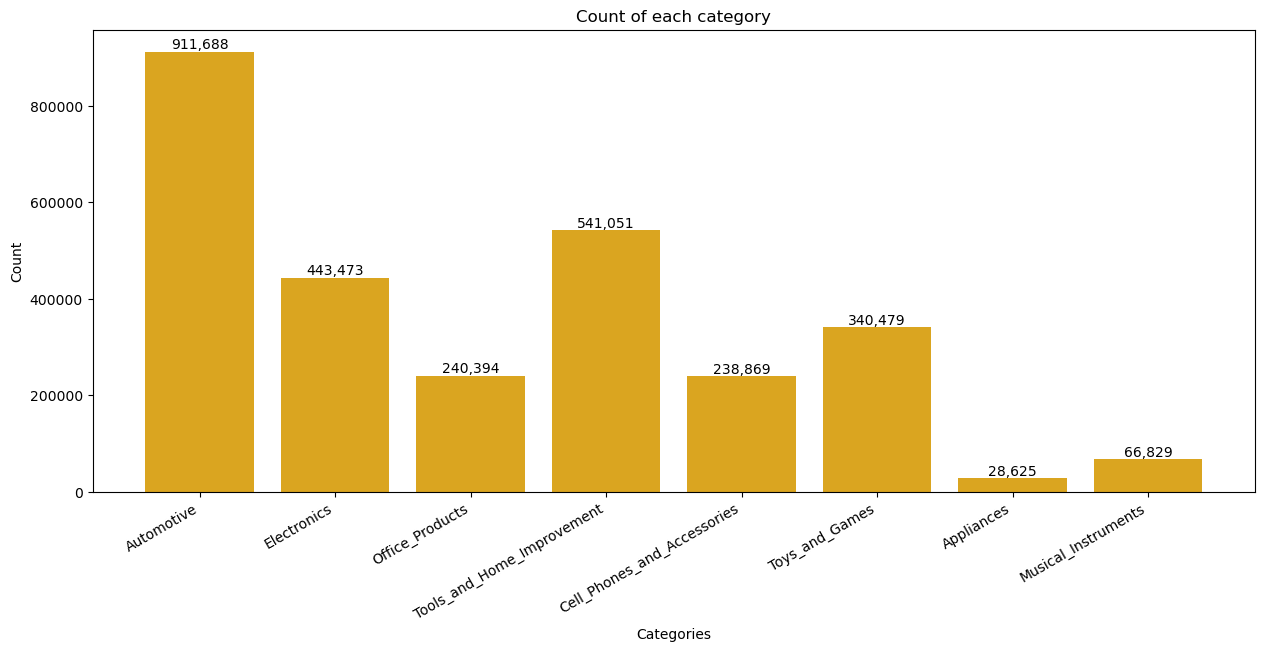

In [76]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('Count of each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

We need to balance the data. We need to craft this dataset such that it is less heavily scewed to cheap items, with an average that's higher than $60. We will also try to balance out the categories - fewer Automotive items.

In [44]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [45]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 408,635 items in the sample


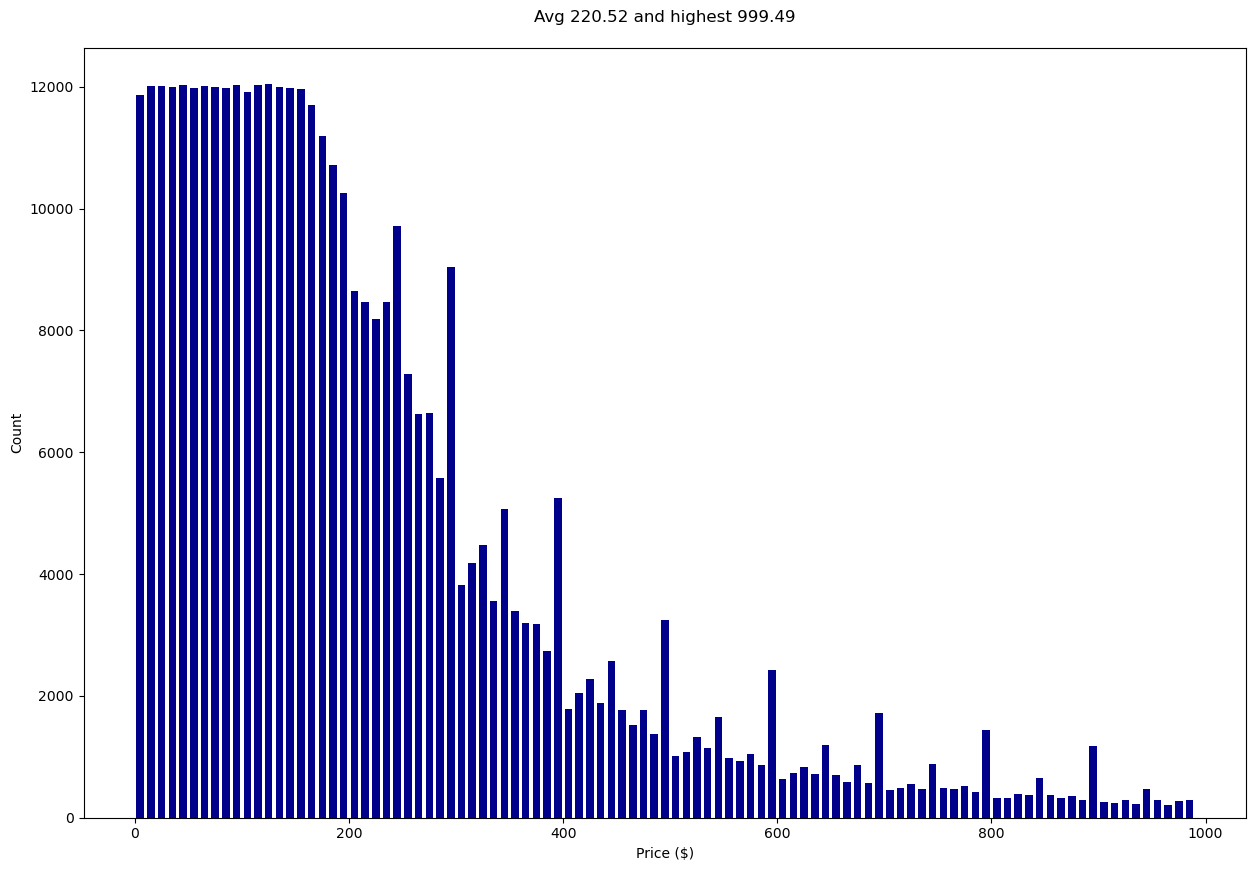

In [46]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

The data is a bit more balanced although its still skewed towards cheaper products. However, this is acceptable to us as this is a reflection of the real world data where the number of cheaper products will be more than the more expensive ones. One more interesting fact that we can see from the above chart is that there is a spike in the number of products which are priced ~399/499/599...

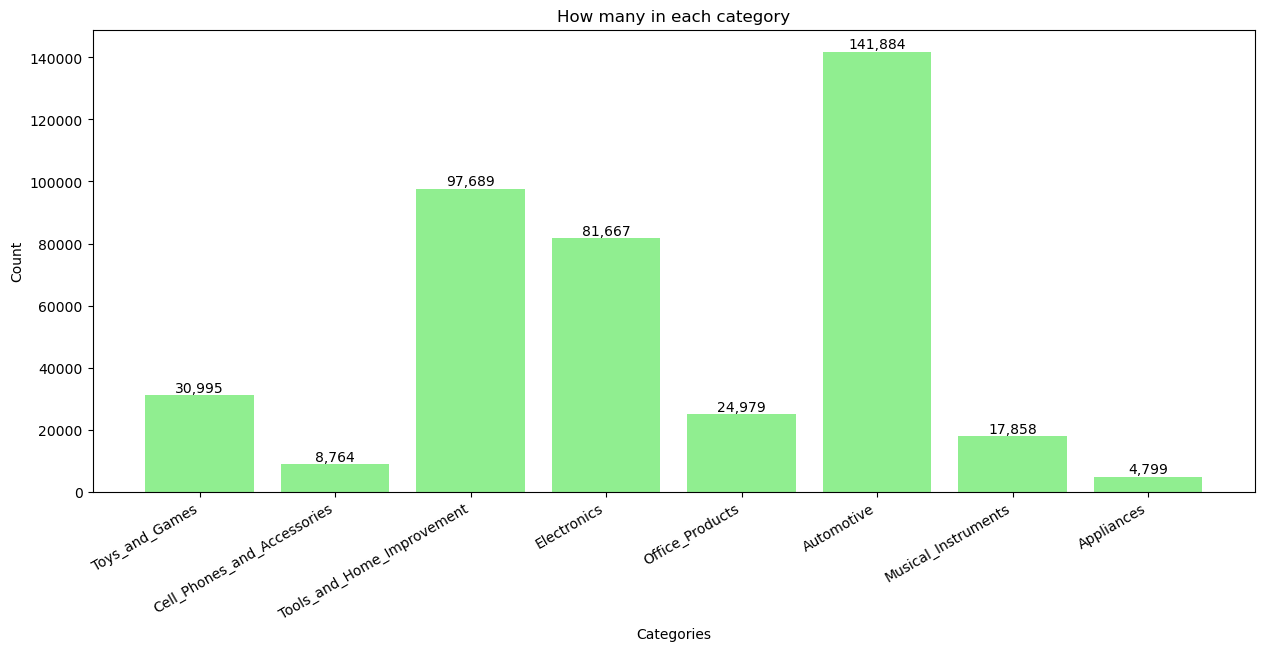

In [47]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

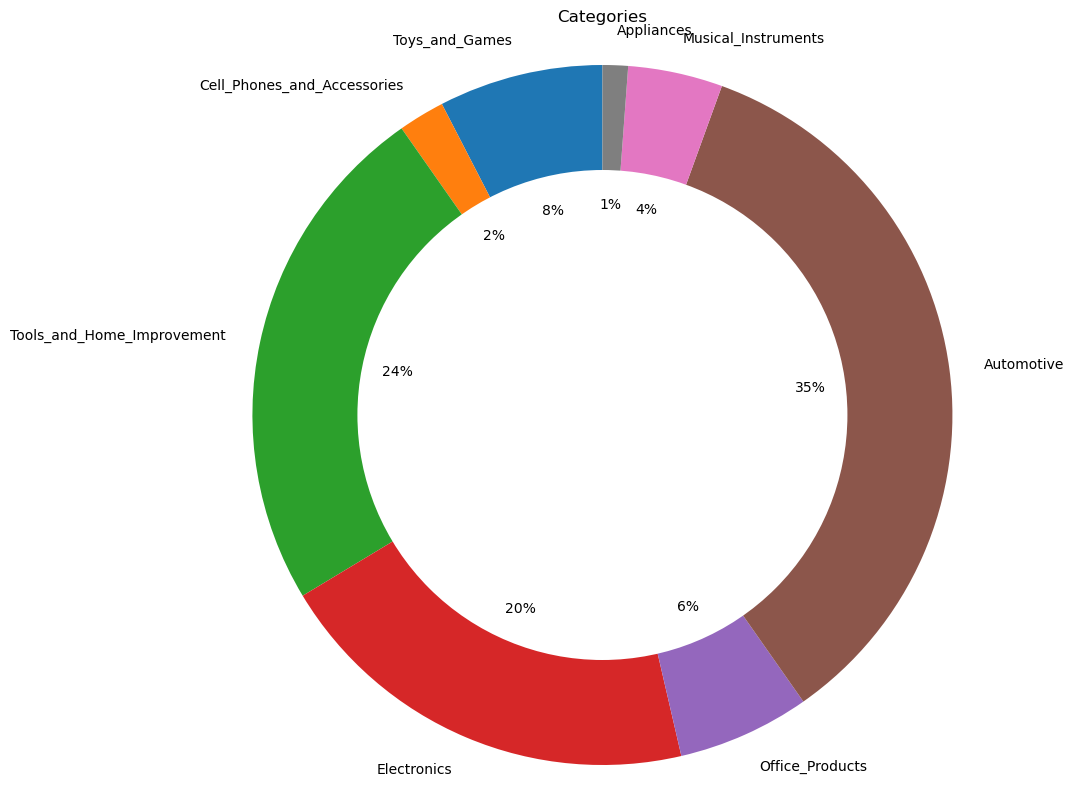

In [48]:
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

Dataset curated. Lets do some final checks

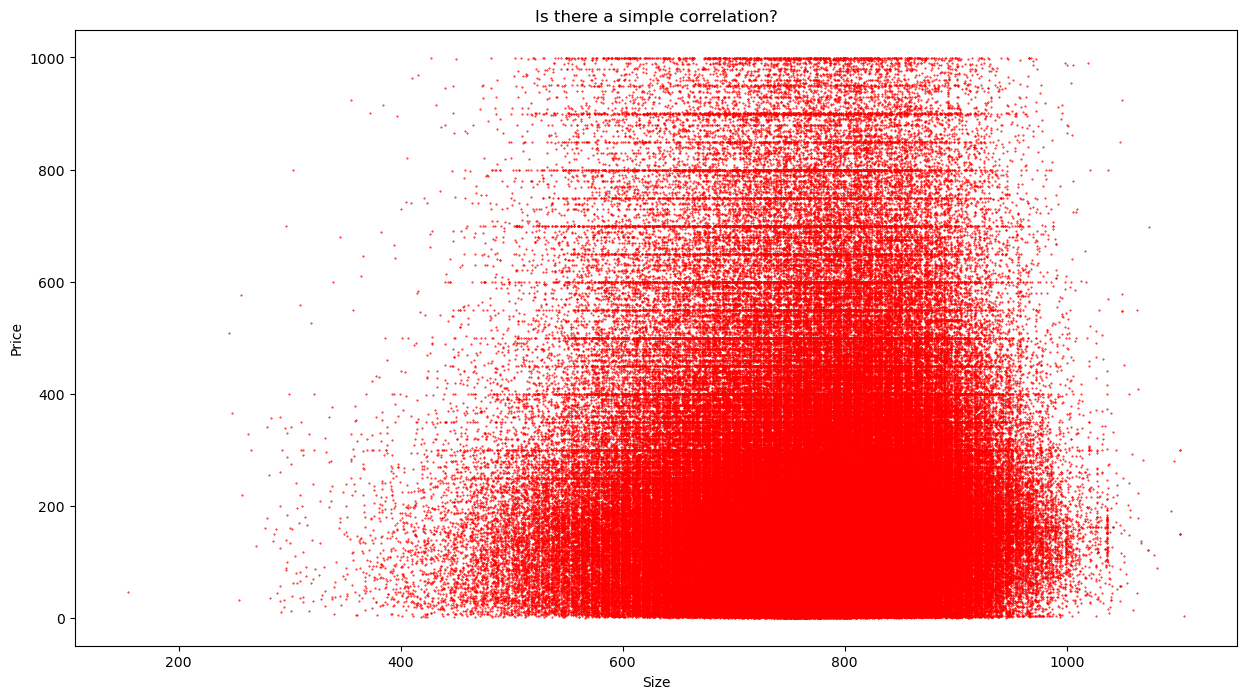

In [49]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

Visually there is a very weak correlation between length of the prompt and the price. 

In [50]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [53]:
report(sample[398203])

How much does this cost to the nearest dollar?

Pioneer 7 Single Din DVD Receiver Apple CarPlay Built in Bluetooth with SiriusXM Satellite Radio Backup Camera Bundle with Sound of Tri-State Lanyard
Pioneer In Dash Single Din 7 Flip out DVD Receiver with Built-in Bluetooth, Satellite Radio Tuner, Antenna, and Bullet Style Backup Camera Package Single Din Motorized Flip Out DVD Receiver with 7 Display Apple CarPlay and Android Auto Compatible Bluetooth hands-free calling and audio streaming SiriusXM Satellite Radio Tuner included, (subscription to service required, not included) Universal Backup Camera Included with FREE SOTS Lanyard Included Is Discontinued No, Available July 22, 2017, Manufacturer Pioneer, Brand Sound of Tri-State, Media Type DVD R, Screen Size 7 Inches, Connectivity Technology Bluetooth

Price is $769.00
[97154, 12053, 24783, 271, 7117, 374, 400, 24619, 13, 410]
[' Connectivity', ' Technology', ' Bluetooth', '\n\n', 'Price', ' is', ' $', '769', '.', '00']


## Train and Test split

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing.


In [54]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


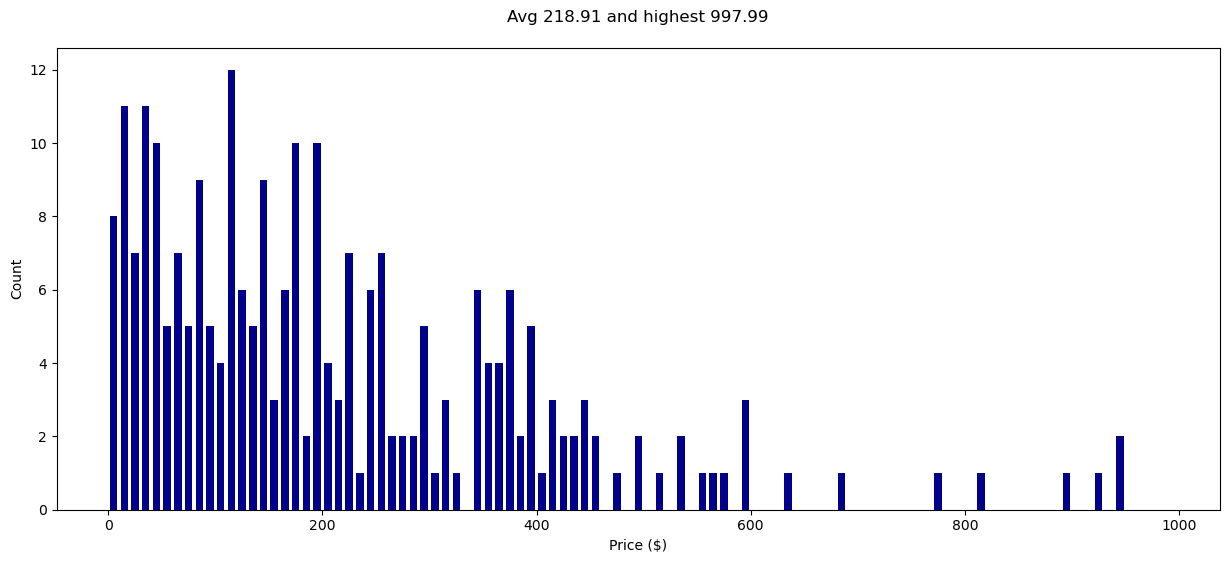

In [55]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

## Upload the new dataset

Convert to prompts and upload to HuggingFace hub

In [56]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [57]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [58]:

HF_USER = "vikramjit"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/vikramjit/pricer-data/commit/9f010c93e540bc481dcf9f7aa76d66a50770c8bb', commit_message='Upload dataset', commit_description='', oid='9f010c93e540bc481dcf9f7aa76d66a50770c8bb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/vikramjit/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='vikramjit/pricer-data'), pr_revision=None, pr_num=None)

In [77]:
# Let's pickle the training and test dataset
def save_pickle(data, filename):
    # Check if file exists and delete if it does
    if os.path.exists(filename):
        os.remove(filename)
    # Save new data
    with open(filename, 'wb') as file:
        pickle.dump(data, file)


In [78]:
# Save train and test datasets
save_pickle(train, 'train.pkl')
save_pickle(test, 'test.pkl')